In [1]:
import numpy as np
import scipy.special
import scipy.stats
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#according to neal, for the robot arm problem Mackay uses improper uniform distributions on the prior hyperparameters, and sets the L variance to its true value
#for his first attempt at the robot arm problem, Neal uses a_neal = 0.2 and w_neal = 1 for input-to-hidden weights and hidden layer biases. The output biases were given a fixed Gauss prior with unit var. For the hidden-to-output weights he sets w_neal = #hidden units
#neal also sets a_neal = 0.2 and w_neal = 100 (so mean variance is 0.1) for L variance hyperprior 
#for his second attempt at the robot arm problem, Neal uses a_neal = 0.1 and w_neal = 100 for input-to-hidden weights and hidden layer biases. The output biases were given a fixed Gauss prior with unit var. For the hidden weights a_neal = 0.1 and w_neal = 100 * #hidden units
#neal sets a_neal = 0.1 and w_neal = 100 for the L variance hyperprior in this case
#for the bh dataset, neal uses similar values to his second attempt at the robot arm, despite the inputs/outputs being scaled to unit variance
#bishop 1998 uses a = 0.25, b = 1 / 400 for the prior hyperparams and a = 0.05, b = 1 / 2000 for the L hyperparams, for the bh data (not sure if they scale data or not)

In [18]:
#GLOBAL VALUES OF GAMMA HYPERPARAMETERS USED
a_neal = 2.
w_neal = 1. * 8
# a_neal = 0.1
# w_neal = 100.
a_bishop = 1.
b_bishop = 1.
a = a_bishop
b = 1. / b_bishop
a = a_neal / 2. 
b = a / w_neal
print "a"
print a
print "b"
print b
mu = 0.

a
1.0
b
0.125


In [19]:
def norm_gamm(x, t):
    lambd = 1.
    mu = 0.
    const = b ** a * np.sqrt(lambd) / (scipy.special.gamma(a) * np.sqrt(2. * np.pi))
    oth = t ** (a - 0.5) * np.exp( - b * t)
    norm = np.exp(- lambd * t / 2. * (x - mu)**2.)
    return const * oth * norm

def norm_gamm_neal(x, t):
    """
    in terms of the notation of the function norm_gamm:
    a = a_neal / 2
    b = a_neal / (2 * w_neal)
    lambd_neal = 1
    """
    const = (a_neal / (2. * w_neal))**(a_neal / 2.) / (scipy.special.gamma(a_neal / 2.) * np.sqrt(2. * np.pi))
    oth = t ** (a_neal / 2. - 1.) * np.exp(- t * a_neal / (2. * w_neal))
    norm = t ** (1. / 2.) * np.exp(- t / 2. * (x - mu)**2.)
    return const * oth * norm

def unit_norm_norm(x, t):
    return np.exp(- 1. / 2. * (x)**2.) * np.exp(- 1. / 2. * (t)**2.)

def gamma(t):
    return b ** a / scipy.special.gamma(a) * t ** (a - 1.) * np.exp(- b * t)

def gamma_neal(t):
    return (a_neal / (2. * w_neal)) ** (a_neal / 2.) / scipy.special.gamma(a_neal / 2.) * t ** (a_neal / 2. - 1.) * np.exp(- a_neal / (2. * w_neal) * t)

def gamma_bishop(t):
    return (1. / b_bishop) ** a_bishop *  1. / scipy.special.gamma(a) * t ** (a_bishop - 1.) * np.exp(- t / b_bishop)

def gamma_scipy(t):
    """
    parameters are as in gamma(t) function
    """
    rv = scipy.stats.gamma(a = a, scale = 1. / b)
    return rv.pdf(t)

def gamma_ppf(p):
    rv = scipy.stats.gamma(a = a, scale = 1. / b)
    return rv.ppf(p)

def rec_gamma(t):
    return gamma_scipy(1. / t)
    
def rec_sqrt_gamma(t):
    return gamma_scipy(1. / np.sqrt(t))

def rec_sqrt_gamma_ppf(p):
    rv = scipy.stats.gamma(a = a, scale = 1. / b)
    return 1. / np.sqrt(rv.ppf(p))

def inv_gamma_scipy(t):
    """
    inverse of precision (pdf of variance)
    """
    rv = scipy.stats.invgamma(a = a, scale = b)
    return rv.pdf(t)

def inv_sqrt_gamma_pdf(t):
    """
    inverse of sqrt of precision (pdf of standard deviation)
    """
    const = 2. * b ** a / scipy.special.gamma(a)
    oth = t ** (-1. * (1. + 2 * a)) * np.exp(-1. * b / t**2)
    return const * oth

def inv_sqrt_gamma_integrand(t, moment):
    return t ** moment * inv_sqrt_gamma_pdf(t)

def inv_sqrt_gamma_int(moment):
    """
    integrates t^moment * inv_sqrt_gamma_pdf
    """
    return scipy.integrate.quad(inv_sqrt_gamma_integrand, 0., np.inf, moment)

def inv_sqrt_gamma_mean():
    """
    analytic solution is (for a > 0.5)
    b ** (0.5) / scipy.special.gamma(a) * scipy.special.gamma(a - 0.5)
    """
    return inv_sqrt_gamma_int(1)[0]

def inv_sqrt_gamma_var():
    """
    analytic solution is (for a > 1)
    b / (a - 1) - b * (scipy.special.gamma(a - 0.5) / scipy.special.gamma(a))**2.
    """
    return inv_sqrt_gamma_int(2)[0] - inv_sqrt_gamma_int(1)[0]**2.


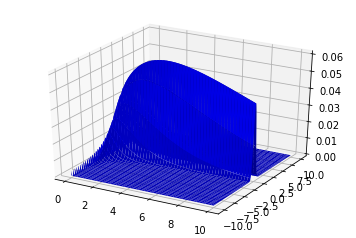

In [20]:
x = np.linspace(-10, 10, 1000)
t = np.linspace(0, 10, 1000)
xx, tt = np.meshgrid(x, t, indexing='ij')
z = norm_gamm_neal(xx, tt)
fig = plt.figure('3d gamma norm')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(tt, xx, z, color='b')

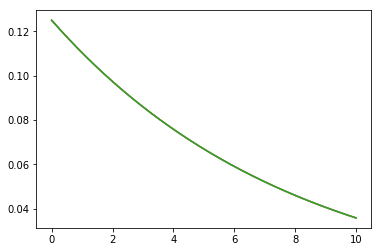

In [21]:
t = np.linspace(0, 10, 1000)
plt.figure('2d gamma')
plt.plot(t, gamma(t))
plt.plot(t, gamma_neal(t))
plt.plot(t, gamma_scipy(t))
#plt.plot(t, gamma_bishop(t))

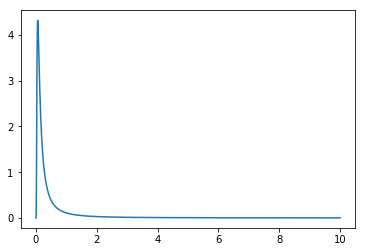

In [22]:
t = np.linspace(0, 10, 1000)
plt.figure('2d inv gamma')
plt.plot(t, inv_gamma_scipy(t))

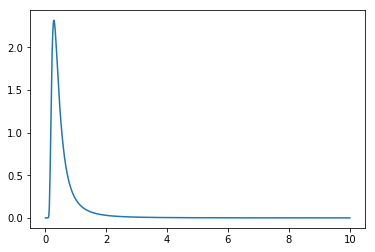

In [23]:
t = np.linspace(0, 10, 1000)
plt.figure('2d inv sqrt gamma')
plt.plot(t[1:], inv_sqrt_gamma_pdf(t[1:]))

/home/kamran/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in divide


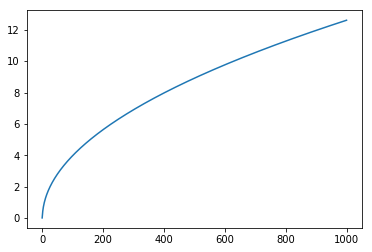

In [60]:
t = np.linspace(0, 1000, 1000)
plt.figure('2d recip gamma')
plt.plot(t, rec_gamma(t))

/home/kamran/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in divide


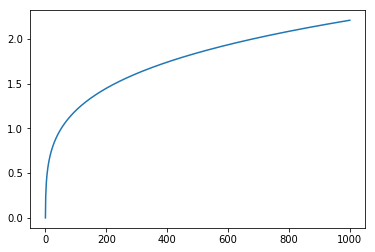

In [58]:
t = np.linspace(0, 1000, 1000)
plt.figure('2d recip sqrt gamma')
plt.plot(t, rec_sqrt_gamma(t))

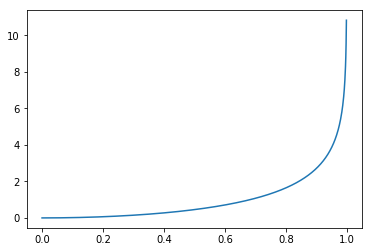

In [99]:
p = np.linspace(0, 1, 1000)
plt.figure('2d gamma ppf')
plt.plot(p, gamma_ppf(p))

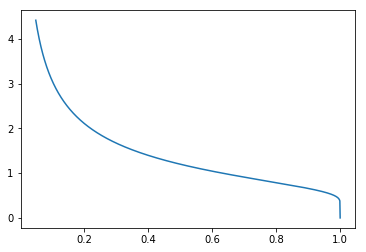

In [64]:
p = np.linspace(0.05, 1, 1000)
plt.figure('2d recip sqrt gamma ppf')
plt.plot(p, rec_sqrt_gamma_ppf(p))

sig low
9.974926690127713
sig high
0.4659906017846562


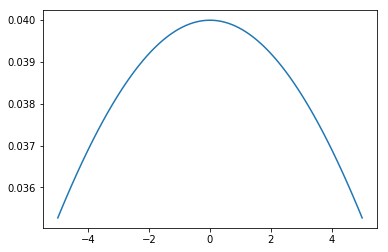

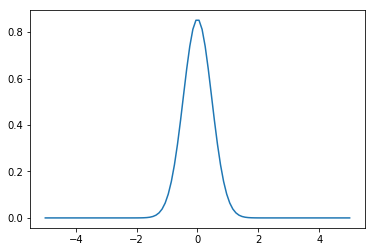

In [65]:
rv = scipy.stats.gamma(a = a, scale = 1. / b)
p_low = 0.01
p_high = 1. - p_low
g_sample_low = rv.ppf(p_low)
g_sample_high = rv.ppf(p_high)
sig_low = 1. / np.sqrt(g_sample_low)
sig_high = 1. / np.sqrt(g_sample_high)
print "sig low"
print sig_low
print "sig high"
print sig_high
x = np.linspace(-5, 5, 100)
plt.figure('2d gauss low prob sig')
plt.plot(x, scipy.stats.norm(mu, sig_low).pdf(x))
plt.figure('2d gauss high prob sig')
plt.plot(x, scipy.stats.norm(mu, sig_high).pdf(x))

/home/kamran/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  


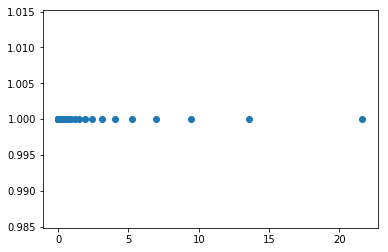

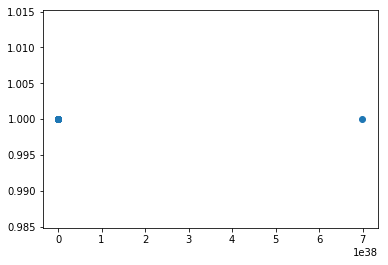

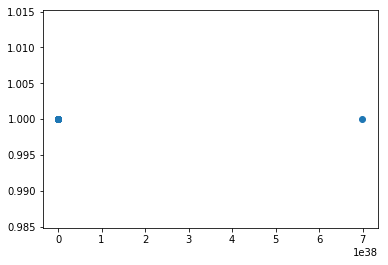

In [19]:
y1 = scipy.stats.gamma(a = a, scale = 1. / b).ppf(np.linspace(0,1,100))
y2 = scipy.stats.invgamma(a = a, scale = b).ppf(np.linspace(0,1,100))
plt.figure('y1')
plt.scatter(x=y1, y=[1]*100)
plt.figure('1/y1')
plt.scatter(x=1./y1, y=[1]*100)
plt.figure('y2')
plt.scatter(x=y2, y=[1]*100)